<a href="https://colab.research.google.com/github/hateley/RAG-chatbot/blob/main/rag_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Question and Answer System using RAG
**Author**: Shannon Hateley, PhD  
**Date**: July 31, 2024

<ins>Overview</ins>  
Building a Question and Answer system that uses RAG from drug trail information on Epkinly and Polivy. This system relies primarily on LangChain.

### Install libraries

**We need:**
* **langchain**: This is a library for GenAI. We'll use it to chain together different language models and components for our chatbot.
* **openai**: This is the official OpenAI Python client. We'll use it to interact with the OpenAI API and generate responses for our chatbot.
* **pinecone-client**: This is the official Pinecone Python client. We'll use it to interact with the Pinecone API and store our chatbot's knowledge base in a vector database.
* **other**: Various data wrangling, visualizing, and text processing libraries

In [188]:
# install libraries

!pip install -qU \
    langchain==0.0.354 \
    openai==1.6.1 \
    pinecone-client==3.1.0 \
    tiktoken==0.5.2 \
    matplotlib \
    seaborn \
    pandas \
    tqdm

## Make a simple chatbot first

In [ ]:
#initialize the ChatOpenAI object

import os
from langchain.chat_models import ChatOpenAI
from google.colab import userdata

chat = ChatOpenAI(
    openai_api_key=userdata.get('testkey'),
    model='gpt-3.5-turbo'
)

In [ ]:
from langchain.schema import (
    SystemMessage,
    HumanMessage,
    AIMessage
)

messages = [
    SystemMessage(content="You are a helpful assistant."),
    HumanMessage(content="Hi AI, how are you today?"),
    AIMessage(content="I'm great thank you. How can I help you?"),
    HumanMessage(content="I'd like to understand string theory.")
]

In [ ]:
#res = chat(messages)
print(res.content)

String theory is a theoretical framework in physics that attempts to reconcile quantum mechanics and general relativity. It posits that the fundamental building blocks of the universe are not point-like particles, but rather tiny, vibrating strings. These strings can give rise to different particles depending on their vibrational patterns.

String theory suggests that there are multiple dimensions beyond the familiar three spatial dimensions and one time dimension. The theory also proposes the existence of different vibrational modes of the strings, which correspond to different particles and forces in the universe.

One of the key ideas in string theory is the concept of supersymmetry, which posits a symmetry between particles with integer spin (bosons) and particles with half-integer spin (fermions). Supersymmetry is believed to help resolve some of the issues in particle physics, such as the hierarchy problem and unifying the fundamental forces of nature.

String theory has generate

In [ ]:
# add history so we can continue the conversation

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="Why do physicists believe it can produce a 'unified theory'?"
)
# add to messages
messages.append(prompt)

# send to chat-gpt
res = chat(messages)

print(res.content)

Physicists believe that string theory has the potential to produce a unified theory because it has the ability to incorporate all of the fundamental forces of nature (gravity, electromagnetism, weak nuclear force, and strong nuclear force) within a single framework. In traditional particle physics, these forces are described by different theories (such as quantum field theory for the Standard Model and general relativity for gravity) that do not easily reconcile with each other.

String theory, on the other hand, offers a more comprehensive and consistent framework that can potentially describe all of these forces in a unified manner. By treating particles as vibrating strings in higher-dimensional spacetime, string theory can naturally incorporate gravity along with the other forces. This suggests that all forces and particles in the universe may emerge from a single underlying theory.

Additionally, string theory provides a way to reconcile quantum mechanics with general relativity, 

In [ ]:
# right now it doesn't know about the info we want to talk about

# add latest AI response to messages
messages.append(res)

# now create a new user prompt
prompt = HumanMessage(
    content="What were the results of the EPCORE NHL-1 trial?"
)
# add to messages
messages.append(prompt)

# send to OpenAI
res = chat(messages)

messages.append(res)

In [ ]:
print(res.content)

The EPCORE NHL-1 trial was a clinical trial evaluating the safety and efficacy of a novel treatment for patients with non-Hodgkin lymphoma (NHL). Unfortunately, as of my last update, I do not have specific information on the results of the EPCORE NHL-1 trial. Clinical trial results are typically published in scientific journals or presented at medical conferences once the study is completed.

If you are interested in the results of the EPCORE NHL-1 trial, I recommend checking clinical trial registries, medical journals, or contacting the researchers involved in the study for more information. Keep in mind that the results of clinical trials can have important implications for patient care and future research in the field of oncology.


## Import data about the clinical trials

In [ ]:
import pandas as pd

df = pd.read_csv("/content/scraped.tsv", sep='\t')
df.columns

Index(['fname', 'text'], dtype='object')

In [ ]:
from langchain.document_loaders import DataFrameLoader

loader = DataFrameLoader(
    df,
    page_content_column="text"
)
docs = loader.load()

In [ ]:
len(docs)

8

In [ ]:
print(docs[0].page_content)

polivy_summary.txt.  POLIVY® (polatuzumab vedotin-piiq) Safety Profile             For Patients and Caregivers         MENU          Order Practice Materials       Order Practice Materials        Prescribing Information        Prescribing Information        Contact a Representative        Contact a Representative        Safety       Safety        3L DLBCL Indication       3L DLBCL Indication    Home  About POLIVY  Unmet Need in DLBCL How POLIVY Is Thought to Work  Efficacy  POLARIX Trial POLARIX Trial Results  Safety  POLIVY Side Effects Important Safety Information  Dosing & Administration  Preparation & Storage POLIVY Dosing Administering POLIVY Dose Modifications  Resources  Printable Resources Helpful Links for Your Patients Helpful Resources for Your Practice Practice Forms & Documents  Financial Support  Financial Assistance Options Eligibility & Enrollment Financial Support FAQs   Order Practice Materials Prescribing Information  Contact a Representative  Safety 3L DLBCL Indicat

In [ ]:
docs[0].metadata

{'fname': 'polivy_summary.txt'}

In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)


tiktoken.encoding_for_model('gpt-3.5-turbo')

<Encoding 'cl100k_base'>

In [ ]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

In [ ]:
print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

Min: 3459
Avg: 6704
Max: 7863


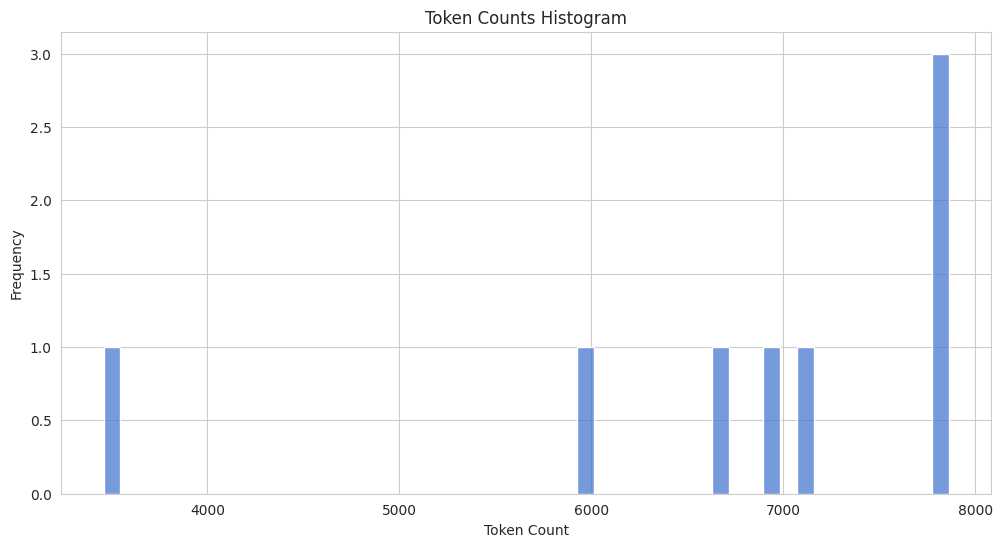

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [ ]:
docs[5].page_content

'epkinly_clinical-trial-results.txt.                 DLBCL Clinical Trial Results - EPKINLY® HCP    Skip to Main content EPKINLY is indicated for the treatment of adults with relapsed or refractory diffuse large B-cell lymphoma (DLBCL), not otherwise specified (NOS), including DLBCL arising from indolent lymphoma, and high-grade B-cell lymphoma (HGBCL) after 2 or more lines of systemic therapy. Approved under accelerated approval based on response rate and durability of response. Continued approval may be contingent upon verification and description of clinical benefit in a confirmatory trial(s). INDICATION X  For US Healthcare Professionals Full Prescribing Information Important Safety Information & Indications For Patients & Care Partners        3L+ Treatment Landscape MOA Efficacy  Study Design & Patient Characteristics Clinical Trial Results  Safety  Adverse Reactions CRS & ICANS Events Important Safety Information  Dosing & Administration  Dosing & Administration Adverse Reaction 

In [ ]:
from tqdm.auto import tqdm

dataset = []

for doc in tqdm(docs):
    source = doc.metadata['fname'].replace('.txt', '')
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        dataset.append({
            'text': chunk,
            'source': source
        })

len(dataset)


  0%|          | 0/8 [00:00<?, ?it/s]

149

In [ ]:
type(dataset[1])

dict

In [ ]:
from pinecone import Pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = userdata.get('pinecone')

# configure client
pc = Pinecone(api_key=api_key)

In [ ]:
from pinecone import ServerlessSpec

spec = ServerlessSpec(
    cloud="aws", region="us-east-1"
)

In [ ]:
import time

index_name = 'trials-rag'
existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        index_name,
        dimension=1536,  # dimensionality of ada 002
        metric='cosine',
        spec=spec
    )
    # wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(index_name)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

embed_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=userdata.get('testkey'))

In [ ]:
from tqdm.auto import tqdm  # for progress bar

data = pd.DataFrame(dataset)
data['chunk-id'] = data.index

batch_size = 100

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i+batch_size)
    # get batch of data
    batch = data.iloc[i:i_end]
    # generate unique ids for each chunk
    ids = [f"{x['chunk-id']}" for i, x in batch.iterrows()]
    # get text to embed
    texts = [x['text'] for _, x in batch.iterrows()]
    # embed text
    embeds = embed_model.embed_documents(texts)
    # get metadata to store in Pinecone
    metadata = [
        {'text': x['text'],
         'source': x['source']} for i, x in batch.iterrows()
    ]
    # add to Pinecone
    index.upsert(vectors=zip(ids, embeds, metadata))

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 149}},
 'total_vector_count': 149}

In [ ]:
from langchain.vectorstores import Pinecone

text_field = "text"  # the metadata field that contains our text

# initialize the vector store object
vectorstore = Pinecone(
    index, embed_model.embed_query, text_field
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.vectorstores.pinecone.Pinecone` was deprecated in langchain-community 0.0.18 and will be removed in 0.2.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/langchain_community/vectorstores/pinecone.py:68: UserWarning: Passing in `embedding` as a Callable is deprecated. Please pass in an Embeddings object instead.
  warnings.warn(


In [ ]:
query = "What were the results of the EPCORE NHL-1 trial?"

vectorstore.similarity_search(query, k=3)

[Document(page_content='Efficacy was evaluated in 148 patients with DLBCL, NOS, including DLBCL arising from indolent lymphoma, and HGBCL.  EPCORE NHL-1 trial   Primary endpoint*: ORR (CR+PR) \xa0 Select secondary endpoints included2*: CR rate, DOR, DOCR, time to response \xa0 KEY INCLUSION CRITERIA3: ECOG PS 0-2 | Prior CAR T allowed | ≥2 prior lines of antineoplastic therapy, including ≥1 anti-CD20 mAb KEY EXCLUSION CRITERIA: CNS involvement of lymphoma | Allogeneic HSCT or solid organ transplant | Ongoing active infection | Known impaired T-cell immunity \xa0 \xa0 \xa0 \xa0 \xa0 \xa0   DOSING SCHEDULE     SUBCUTANEOUS EPKINLY 48 mg Weekly, cycles 1†-3 Every other week, cycles 4-9 Every 4 weeks, cycles 10+ \xa0 Cycle=28 days.    Patients continued to receive EPKINLY until disease progression or unacceptable toxicity.  Strategies to minimize occurrence and severity of CRS: Step-up dosage: step-up dose 1 of 0.16 mg on C1D1, step-up dose 2 of 0.8 mg on C1D8, and full dose of 48 mg on C1

In [ ]:
def augment_prompt(query: str):
    # get top 3 results from knowledge base
    results = vectorstore.similarity_search(query, k=3)
    # get the text from the results
    source_knowledge = "\n".join([x.page_content for x in results])
    # feed into an augmented prompt
    augmented_prompt = f"""Using the contexts below, answer the query.

    Contexts:
    {source_knowledge}

    Query: {query}"""
    return augmented_prompt

In [ ]:
print(augment_prompt(query))

Using the contexts below, answer the query.

    Contexts:
    Efficacy was evaluated in 148 patients with DLBCL, NOS, including DLBCL arising from indolent lymphoma, and HGBCL.  EPCORE NHL-1 trial   Primary endpoint*: ORR (CR+PR)   Select secondary endpoints included2*: CR rate, DOR, DOCR, time to response   KEY INCLUSION CRITERIA3: ECOG PS 0-2 | Prior CAR T allowed | ≥2 prior lines of antineoplastic therapy, including ≥1 anti-CD20 mAb KEY EXCLUSION CRITERIA: CNS involvement of lymphoma | Allogeneic HSCT or solid organ transplant | Ongoing active infection | Known impaired T-cell immunity               DOSING SCHEDULE     SUBCUTANEOUS EPKINLY 48 mg Weekly, cycles 1†-3 Every other week, cycles 4-9 Every 4 weeks, cycles 10+   Cycle=28 days.    Patients continued to receive EPKINLY until disease progression or unacceptable toxicity.  Strategies to minimize occurrence and severity of CRS: Step-up dosage: step-up dose 1 of 0.16 mg on C1D1, step-up dose 2 of 0.8 mg on C1D8, and full dose of

In [ ]:
# create a new user prompt
prompt = HumanMessage(
    content=augment_prompt(query)
)
# add to messages
messages.append(prompt)

res = chat(messages)

print(res.content)

The results of the EPCORE NHL-1 trial showed that the primary endpoint, which was the Overall Response Rate (ORR) defined as complete response (CR) plus partial response (PR), was evaluated in 148 patients with Diffuse Large B-Cell Lymphoma (DLBCL), Not Otherwise Specified (NOS), including DLBCL arising from indolent lymphoma, and High-Grade B-Cell Lymphoma (HGBCL). The trial also evaluated select secondary endpoints, including CR rate, duration of response (DOR), duration of CR (DOCR), and time to response.

The dosing schedule for the subcutaneous administration of EPKINLY included a step-up dosage strategy to minimize the occurrence and severity of cytokine release syndrome (CRS). Patients received EPKINLY until disease progression or unacceptable toxicity. Adverse reactions, including CRS, were managed with dosing modifications and prophylactic treatment with corticosteroids, antihistamines, and antipyretics.

Overall, the trial demonstrated efficacy in heavily pretreated patients 